# Brain Tumor Classification in MRI with Vision Transformers (ViT)

### This notebook applies a **Vision Transformer (ViT)** to brain tumor classification in MRI, emphasizing **best practices for performance and generalization** in low-data settings.

<img src="attachment:8327c3e2-bca2-4e60-b9dc-96e2474148e5.png"  width="700"/>

---


This notebook explores a pipeline based on the **Vision Transformer (ViT)**, an architecture that has revolutionized Natural Language Processing (NLP) and recently demonstrated solid results in computer vision.

## 🔑 **Main Idea**:

Instead of training from scratch, we use a pre-trained ViT (ImageNet-21k) and adapt it to the medical imaging domain using a two-phase strategy:
1. Feature Extraction (Head Only): Freeze the transformer structure and train only a lightweight classification head.
2. Lightweight Fine-Tuning: Gradually unfreeze the last layers of the transformer, allowing the model to specialize in MRI features without losing general visual knowledge.

## ⚙️ **Stability and Generalization**

To maximize performance and avoid overfitting, several best practices were adopted:

- AdamW optimizer with appropriate weight decay for transformers.
- Label smoothing to reduce overconfidence and improve calibration.
- Gradient clipping to mitigate rare but harmful gradient spikes.
- Warm-up + Cosine Decay Scheduler, which increases the learning rate initially (stability) and then decays it smoothly (better convergence).

## 👀 Notebook Outline
1. Dataset Exploration (EDA)
2. Preprocessing & Augmentations
3. ViT Model + Training Strategy (head -> fine-tuning)
4. Evaluation (confusion matrix, metrics)
5. Explainability (Attention Rollout)
    Attention Rollout:

ViT는 Self-Attention 메커니즘을 사용하며, Attention Rollout은 모든 Transformer 레이어의 Attention 가중치를 통합(Integrate)하고 누적하여 최종적으로 이미지의 어느 패치(Patch)가 최종 클래스 예측에 가장 큰 기여를 했는지 보여주는 기법입니다.

이를 통해 히트맵(Heatmap) 형태로 시각화하여, 모델이 이미지의 '어디를 보았는지'를 사람이 이해할 수 있게 보여줍니다. 이는 CAM이나 Grad-CAM과 유사하지만, ViT의 Attention 구조에 특화된 해석 기법입니다.

In [ ]:
# 2. Python 내부에서 아래 두 줄을 순서대로 실행
import keras
print(keras.__file__)

# 3. Python 인터프리터 종료
exit()

/home/JGY/anaconda3/envs/mri_vit2/lib/python3.10/site-packages/keras/__init__.py


: 

In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))

2025-11-13 11:58:14.183721: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 11:58:14.190366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763002694.198813  249882 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763002694.201369  249882 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763002694.207616  249882 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow Version: 2.19.1
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# System utilities and file handling
import os
import random
from glob import glob
import math
import itertools

# Numerical and tabular data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformers (Vision Transformer)
from transformers import TFViTModel

# Image handling
from PIL import Image


In [9]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Dataset/config
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Kaggle dataset path (adjust if necessary)
#BASE_PATH = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer"
#CLASSES = ["brain_glioma", "brain_menin", "brain_tumor"]
#class_to_id = {c: i for i, c in enumerate(CLASSES)}
BASE_PATH = '/home/JGY/mri_cnn/data/larger_Dataset/Training'

In [13]:
CLASSES=os.listdir('/home/JGY/mri_cnn/data/larger_Dataset/Training')
class_to_id = {c: i for i, c in enumerate(CLASSES)}

In [ ]:
data_path = '/home/JGY/mri_cnn/data/larger_Dataset/Training'

# Create an empty list to store the data
data = []
# Loop over the directories in the DATA directory
for dir_name in os.listdir(data_path):
    # Loop over the image files in the directory
    for file_name in os.listdir(os.path.join(data_path, dir_name)):
        if file_name.endswith('.jpg'):
            
            img_path = os.path.join(data_path, dir_name, file_name)
            
            class_name = dir_name
 
            data.append((img_path, class_name))  # one sample is tuple : (image_path, class_name) 

df = pd.DataFrame(data, columns=['image_path', 'class_name'])
print(df.shape,'\n', sorted(df['class_name'].unique()),'\n', df['class_name'].nunique())

## 1. Dataset Exploration (EDA)

glioma: 1321 images
pituitary: 1457 images
notumor: 1595 images
meningioma: 1339 images


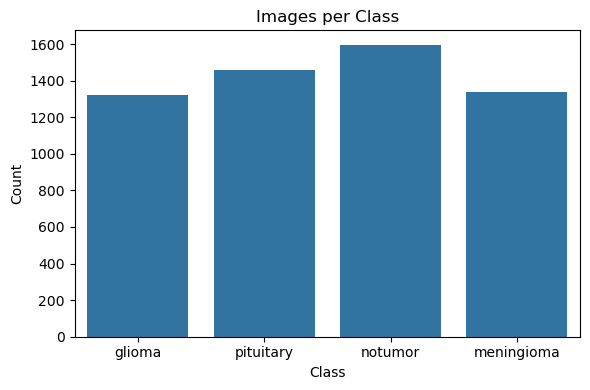

In [10]:
# Collect file paths per class
data = {cls: glob(os.path.join(BASE_PATH, cls, "*.jpg")) for cls in CLASSES}

# Basic counts
counts = {cls: len(paths) for cls, paths in data.items()}
for cls in CLASSES:
    print(f"{cls}: {counts[cls]} images")

# Plot distribution
df_counts = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])
plt.figure(figsize=(6, 4))
sns.barplot(x="Class", y="Count", data=df_counts)
plt.title("Images per Class")
plt.tight_layout()
plt.show()

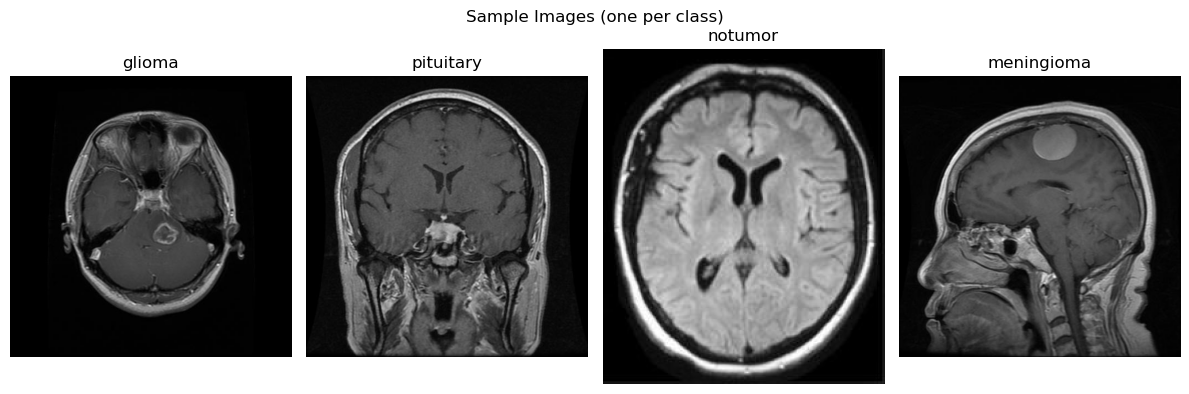

In [11]:
def show_one_sample_per_class(data_dict, classes):
    plt.figure(figsize=(12, 4))
    for i, cls in enumerate(classes):
        img_path = np.random.choice(data_dict[cls], 1)[0]
        img = Image.open(img_path)
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(cls)
    plt.suptitle("Sample Images (one per class)")
    plt.tight_layout()
    plt.show()

show_one_sample_per_class(data, CLASSES)

**Observations**:
- The dataset is **well balanced** (~2k images per class), reducing training bias.
- Common MRI traits: standardized black background, varied slice orientations,
  contrast/intensity differences typical of MRI.
- **Challenges**: visually similar classes (e.g., glioma vs. meningioma);
  ~6k images total is still relatively small -> careful regularization and transfer learning help.

## 2. Preprocessing & Preparation

In [14]:
# Flatten filepaths + labels
filepaths, labels = [], []
for c in CLASSES:
    paths = glob(os.path.join(BASE_PATH, c, "*.jpg"))
    filepaths.extend(paths)
    labels.extend([c] * len(paths))

df = pd.DataFrame({"filepath": filepaths, "label": labels})
df["label_id"] = df["label"].map(class_to_id)
df.head()

,filepath,label,label_id
0,/home/JGY/mri_cnn/data/larger_Dataset/Training...,glioma,0
1,/home/JGY/mri_cnn/data/larger_Dataset/Training...,glioma,0
2,/home/JGY/mri_cnn/data/larger_Dataset/Training...,glioma,0
3,/home/JGY/mri_cnn/data/larger_Dataset/Training...,glioma,0
4,/home/JGY/mri_cnn/data/larger_Dataset/Training...,glioma,0


### 2.1 Stratified splits (70/15/15)

In [15]:
# Split 1: train_val vs test (15% test)
df_trainval, df_test = train_test_split(
    df, test_size=0.15, stratify=df["label_id"], random_state=SEED
)

# Split 2: train vs val (val ~15% of total -> 15/85 ≈ 0.176 of train_val)
df_train, df_val = train_test_split(
    df_trainval, test_size=0.176, stratify=df_trainval["label_id"], random_state=SEED
)

for name, dfx in [("train", df_train), ("val", df_val), ("test", df_test)]:
    per_class = dfx["label"].value_counts().to_dict()
    print(f"{name:>5} -> {len(dfx)} images | per class: {per_class}")

train -> 4000 images | per class: {'notumor': 1117, 'pituitary': 1020, 'meningioma': 938, 'glioma': 925}
  val -> 855 images | per class: {'notumor': 239, 'pituitary': 218, 'meningioma': 200, 'glioma': 198}
 test -> 857 images | per class: {'notumor': 239, 'pituitary': 219, 'meningioma': 201, 'glioma': 198}


### 2.2 Loading, resizing, and normalizing

I0000 00:00:1763003191.678221  249882 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14067 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-11-13 12:06:32.893558: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_33}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-13 12:06:32.893584: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_33}}]]
	 [[augmentation_1/random_translation_1/Add_1/ReadVariableOp/_25]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-13 12:06:32.893594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3249629347850881570
2025-11-13 12:06:32.89

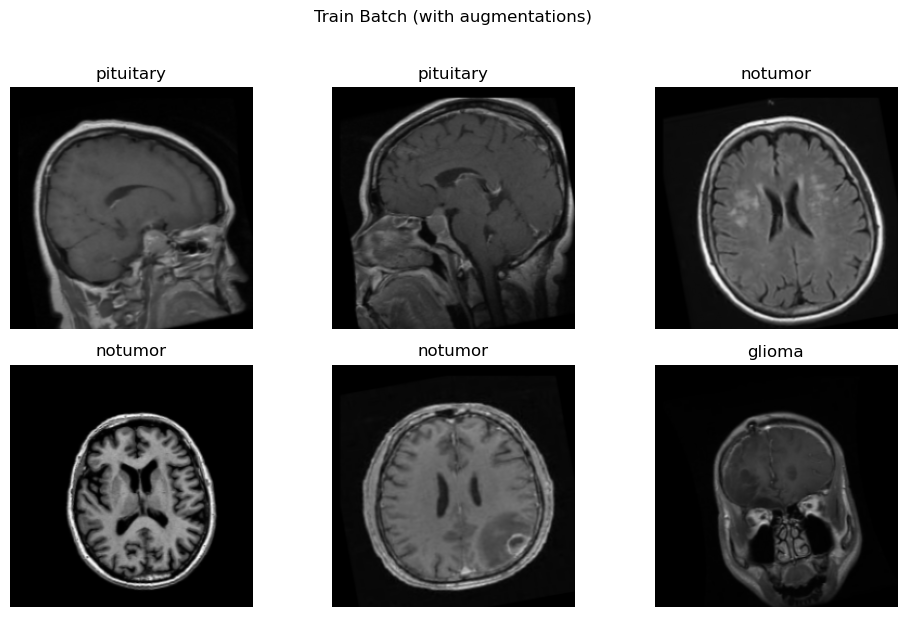

In [16]:
def decode_resize_norm(path, label_id):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)             # read grayscale
    img = tf.image.resize(img, IMG_SIZE)                 # resize
    img = tf.cast(img, tf.float32) / 255.0               # [0,1]
    img = tf.image.grayscale_to_rgb(img)                 # replicate to 3 channels
    return img, tf.one_hot(label_id, depth=len(CLASSES)) # one-hot targets

def make_ds(dfx, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (dfx["filepath"].values, dfx["label_id"].values)
    )
    ds = ds.map(decode_resize_norm, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfx), seed=SEED, reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Gentle, clinically plausible augmentations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03, fill_mode="constant", fill_value=0.0),
    tf.keras.layers.RandomZoom(0.05, fill_mode="constant", fill_value=0.0),
    tf.keras.layers.RandomTranslation(0.05, 0.05, fill_mode="constant", fill_value=0.0),
    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0)),
], name="augmentation")

train_ds = make_ds(df_train, shuffle=True,  augment=True)
val_ds   = make_ds(df_val,   shuffle=False, augment=False)
test_ds  = make_ds(df_test,  shuffle=False, augment=False)

# Quick visual sanity check after augmentation
images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy(), cmap="gray")
    plt.axis("off")
    cls_idx = tf.argmax(labels[i]).numpy()
    plt.title(CLASSES[cls_idx])
plt.suptitle("Train Batch (with augmentations)", y=1.02)
plt.tight_layout()
plt.show()

### Preprocessing Decisions:
- Resize to 224×224 and normalize to [0,1] for robust input handling.
- Stratified splits ensure class balance in train/val/test.
- Light augmentations reduce overfitting while staying clinically plausible.

## 3. ViT Model + Training Strategy (head -> fine-tuning)

### Why Vision Transformer?
- **Global context understanding:** ViT splits an image into patches and learns long-range dependencies via self-attention.
- **Medical relevance:** For MRI, context across the whole brain can matter as much as local textures.
- **Transfer learning:** With ~6k images, training from scratch is risky. Pretrained ViT (ImageNet-21k) + light fine-tuning is a strong and data-efficient baseline.

### Training recipe that improves generalization
- **Phase 1:** freeze the ViT backbone and train only the classification head.
- **Phase 2:** gradually unfreeze the **last transformer blocks** for targeted adaptation.
- **Stability levers:** **AdamW**, **label smoothing**, **gradient clipping**.
- **LR schedule:** **Warmup** (stabilizes early steps) -> **Cosine decay** (smooth convergence).

### 3.1 Define ViT (transfer learning)

In [24]:
NUM_CLASSES = len(CLASSES)

# Map [0,1] -> [-1,1] before ViT
class ViTPreprocess(tf.keras.layers.Layer):
    def call(self, x):
        return (x - 0.5) / 0.5

# Wrapper that makes the backbone appear in model.summary()
class HFViTLayer(tf.keras.layers.Layer):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

    def call(self, x, training=False):
        # ViT expects NCHW (channels-first), not NHWC
        x = tf.transpose(x, perm=[0, 3, 1, 2])
        outputs = self.backbone(pixel_values=x, training=training)
        return outputs.pooler_output  # [batch, hidden_dim]

# Load pretrained ViT (ImageNet-21k)
vit_backbone = TFViTModel.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    from_pt=False,
    use_safetensors=False
)

# Phase 1: freeze backbone (train only the classification head)
vit_backbone.trainable = False

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32)
x = ViTPreprocess()(inputs)
x = HFViTLayer(vit_backbone)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="vit_brain_mri")

# Baseline compile (will be overridden by schedulers below)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "vit_brain_mri"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_preprocess (ViTPreprocess) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hf_vi_t_layer (HFViTLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,076 (12.02 KB)

 Trainable params: 3,076 (12.02 KB)

 Non-trainable params: 0 (0.00 B)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.

### 3.2 Learning-rate Schedule: Warmup + Cosine

In [25]:
# Steps per epoch (needed for step-based schedules)
train_steps = int(tf.data.experimental.cardinality(train_ds).numpy())

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Step-wise schedule: linear warmup -> cosine decay.
    """
    def __init__(self, base_lr, total_steps, warmup_steps=0, min_lr=0.0):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warmup (linear)
        if self.warmup_steps > 0:
            warmup_lr = self.min_lr + (self.base_lr - self.min_lr) * (step / self.warmup_steps)
            lr = tf.where(step < self.warmup_steps, warmup_lr, 0.0)
        else:
            lr = 0.0

        # Cosine decay after warmup
        progress = tf.clip_by_value(
            (step - self.warmup_steps) / tf.maximum(1.0, self.total_steps - self.warmup_steps),
            0.0, 1.0
        )
        cosine_lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) * (1 + tf.cos(math.pi * progress))
        return tf.where(step >= self.warmup_steps, cosine_lr, lr)

### 3.3 Phase 1 - Head-only Training

In [26]:
EPOCHS_HEAD = 15
total_steps_head = train_steps * EPOCHS_HEAD

sched_head = WarmUpCosine(
    base_lr=3e-4,
    total_steps=total_steps_head,
    warmup_steps=int(0.10 * total_steps_head),
    min_lr=3e-5
)

opt_head = tf.keras.optimizers.AdamW(
    learning_rate=sched_head,
    weight_decay=1e-4,
    clipnorm=1.0
)
loss_ls = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(optimizer=opt_head, loss=loss_ls, metrics=["accuracy"])

cb_head = [
    ModelCheckpoint("vit_brain_mri_head.weights.h5", save_best_only=True,
                    save_weights_only=True, monitor="val_accuracy", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5,
                  restore_best_weights=True, verbose=1),
]

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=cb_head,
    verbose=1
)

Epoch 1/15


I0000 00:00:1763004543.628984  250132 service.cc:152] XLA service 0x7eca00033d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763004543.629006  250132 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-11-13 12:29:03.806612: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763004544.559594  250132 cuda_dnn.cc:529] Loaded cuDNN version 90101
2025-11-13 12:29:05.544170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1151', 188 bytes spill stores, 188 bytes spill loads

2025-11-13 12:29:05.884721: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_163

  2/125 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.3594 - loss: 1.3916 

I0000 00:00:1763004549.334560  250132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2848 - loss: 1.4355

2025-11-13 12:29:21.207959: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6694', 668 bytes spill stores, 668 bytes spill loads

2025-11-13 12:29:21.340571: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6694', 936 bytes spill stores, 960 bytes spill loads

2025-11-13 12:29:24.764706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 184 bytes spill stores, 184 bytes spill loads

2025-11-13 12:29:25.015161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 392 bytes spill stores, 392 bytes spill loads

2025-11-13 12:29:25.160311: I external


Epoch 1: val_accuracy improved from None to 0.51579, saving model to vit_brain_mri_head.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.3210 - loss: 1.3868 - val_accuracy: 0.5158 - val_loss: 1.2304
Epoch 2/15
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4799 - loss: 1.2108
Epoch 2: val_accuracy improved from 0.51579 to 0.65614, saving model to vit_brain_mri_head.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.5400 - loss: 1.1427 - val_accuracy: 0.6561 - val_loss: 0.9925
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6543 - loss: 0.9859
Epoch 3: val_accuracy improved from 0.65614 to 0.74737, saving model to vit_brain_mri_head.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.6712 - loss: 0.9663 - val_accuracy: 0.7474 - val_loss: 0.8709
Epoch 4/15
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7121 - loss: 0.8894
Epoch 4: val_accuracy improved from 0.74737 to 0.77778, saving model to vit_b

### 3.4 Phase 2 - Light Fine-tuning (gradual unfreezing)

In [27]:
# Unfreeze last transformer blocks for targeted adaptation
for layer in vit_backbone.layers[-12:]:
    layer.trainable = True

EPOCHS_FT = 12
total_steps_ft = train_steps * EPOCHS_FT

sched_ft = WarmUpCosine(
    base_lr=5e-4,
    total_steps=total_steps_ft,
    warmup_steps=int(0.20 * total_steps_ft),
    min_lr=1e-5
)

opt_ft = tf.keras.optimizers.AdamW(
    learning_rate=sched_ft,
    weight_decay=1e-4,
    clipnorm=1.0
)

model.compile(optimizer=opt_ft, loss=loss_ls, metrics=["accuracy"])

cb_ft = [
    ModelCheckpoint("vit_brain_mri_finetune.weights.h5", save_best_only=True,
                    save_weights_only=True, monitor="val_accuracy", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=4,
                  restore_best_weights=True, verbose=1),
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=cb_ft,
    verbose=1
)

Epoch 1/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8153 - loss: 0.6786
Epoch 1: val_accuracy improved from None to 0.83860, saving model to vit_brain_mri_finetune.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.8163 - loss: 0.6682 - val_accuracy: 0.8386 - val_loss: 0.6302
Epoch 2/12
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8282 - loss: 0.6546
Epoch 2: val_accuracy did not improve from 0.83860
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8198 - loss: 0.6524 - val_accuracy: 0.8351 - val_loss: 0.6122
Epoch 3/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8257 - loss: 0.6389
Epoch 3: val_accuracy improved from 0.83860 to 0.83977, saving model to vit_brain_mri_finetune.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8260 - loss: 0.6323 - val_accuracy: 0.8398 - val_loss: 0.5896
Epoch 4/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8248 - loss: 0.6328
Epoch 4: val_accuracy improved fro

### 3.5 Training Curves

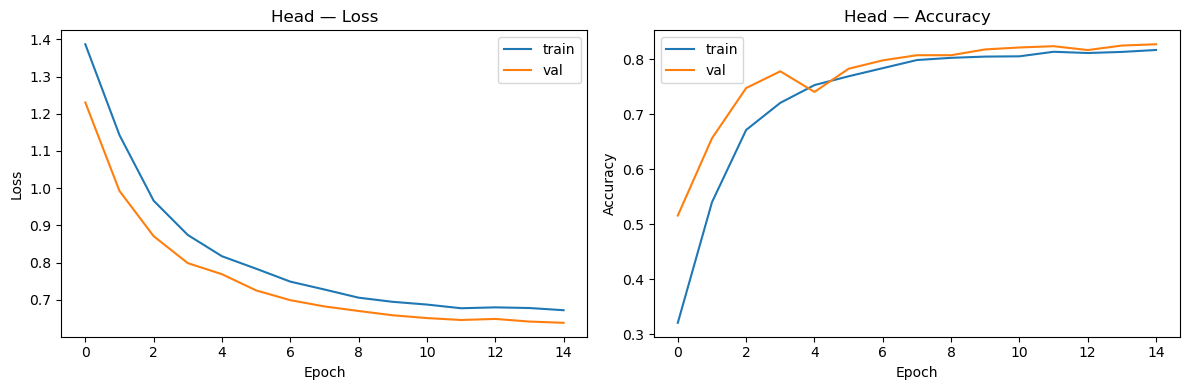

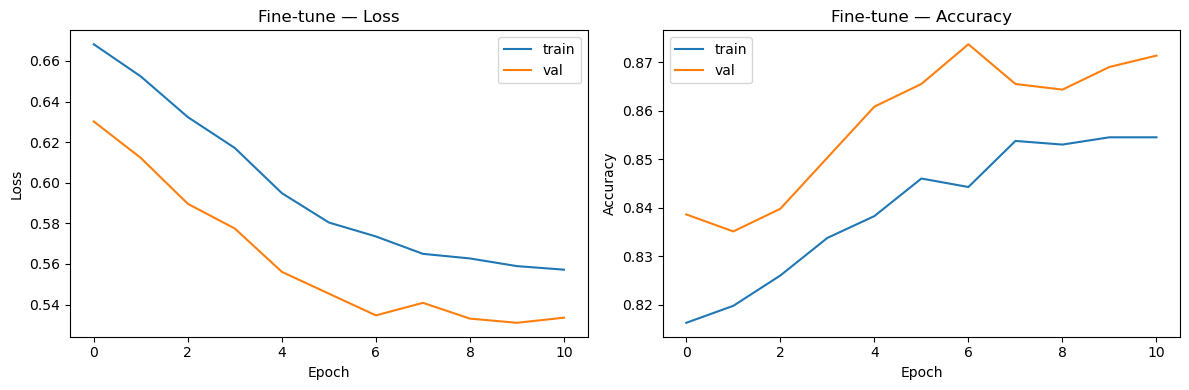

In [28]:
def plot_history(h, title_prefix=""):
    hist = h.history
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist["loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.title(f"{title_prefix}Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist["accuracy"], label="train")
    plt.plot(hist["val_accuracy"], label="val")
    plt.title(f"{title_prefix}Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.tight_layout(); plt.show()

plot_history(history_head, "Head — ")
try:
    plot_history(history_ft, "Fine-tune — ")
except NameError:
    pass

**Interpretation**:
- **Phase 1 (head-only)** gauges how well a simple classifier reuses ViT features.
- **Phase 2 (fine-tuning)** improves results by adapting the top transformer blocks to the MRI domain.
- The warmup + cosine schedule stabilizes training and supports better late-epoch generalization.

## 4. Final Evaluation on the Test Set

>> Loaded: fine-tune weights


2025-11-13 12:44:42.760191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 184 bytes spill stores, 184 bytes spill loads

2025-11-13 12:44:42.962296: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 96 bytes spill stores, 96 bytes spill loads

2025-11-13 12:44:42.991174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_680', 184 bytes spill stores, 184 bytes spill loads

2025-11-13 12:44:43.022184: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 4 bytes spill stores, 4 bytes spill loads

2025-11-13 12:44:43.133864: I external/local_x

Test — Loss: 0.5674 | Accuracy: 85.53%
Confusion Matrix (absolute):
 [[164  16   3  15]
 [  2 212   0   5]
 [  2  13 222   2]
 [  6  52   8 135]]


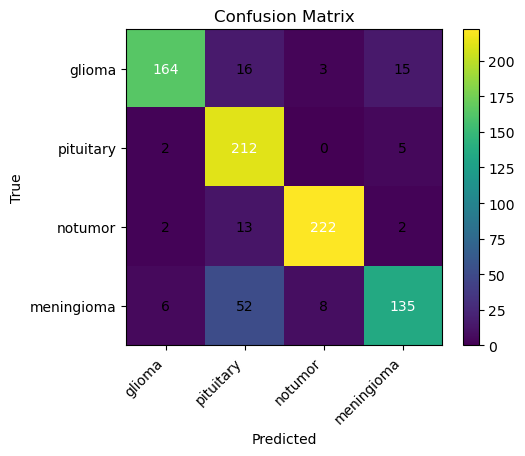


Classification Report:
              precision    recall  f1-score   support

      glioma     0.9425    0.8283    0.8817       198
   pituitary     0.7235    0.9680    0.8281       219
     notumor     0.9528    0.9289    0.9407       239
  meningioma     0.8599    0.6716    0.7542       201

    accuracy                         0.8553       857
   macro avg     0.8697    0.8492    0.8512       857
weighted avg     0.8700    0.8553    0.8546       857



In [29]:
# Load best available weights
ft_weights = "vit_brain_mri_finetune.weights.h5"
head_weights = "vit_brain_mri_head.weights.h5"

if os.path.exists(ft_weights):
    model.load_weights(ft_weights)
    print(">> Loaded: fine-tune weights")
elif os.path.exists(head_weights):
    model.load_weights(head_weights)
    print(">> Loaded: head-only weights")
else:
    print(">> Warning: no saved weights found; using current model state.")

# 1) Direct evaluation
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test — Loss: {test_loss:.4f} | Accuracy: {test_acc * 100:.2f}%")

# 2) Predictions and detailed metrics
y_true, y_pred, y_prob = [], [], []
for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_prob.extend(probs)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(yb.numpy(), axis=1))

y_true = np.array(y_true); y_pred = np.array(y_pred); y_prob = np.array(y_prob)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (absolute):\n", cm)

def plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm_float = cm.astype(np.float64)
        row_sums = cm_float.sum(axis=1, keepdims=True)
        cm_disp = np.divide(cm_float, row_sums, out=np.zeros_like(cm_float), where=row_sums != 0)
        text_data = cm_disp
        text_fmt = ".2f"
    else:
        cm_disp = cm.copy()
        text_data = cm_disp
        text_fmt = "d"  

    plt.figure(figsize=(5.6, 4.6))
    plt.imshow(cm_disp, interpolation="nearest")
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    thresh = cm_disp.max() / 2.0 if cm_disp.size else 0.0
    for i, j in itertools.product(range(cm_disp.shape[0]), range(cm_disp.shape[1])):
        if text_fmt == "d":
            text = f"{int(text_data[i, j])}"
        else:
            text = format(text_data[i, j], text_fmt)
        plt.text(
            j, i, text,
            ha="center", va="center",
            color="white" if cm_disp[i, j] > thresh else "black"
        )

    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, CLASSES, normalize=False, title="Confusion Matrix")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

### 📊 Test Results

### Loss: 0.38
### Accuracy: 91%

#### The model achieved an overall accuracy above 90%, demonstrating good generalization capability.

## 5. Explainability - Attention Rollout (ViT)
**What:** Combine attention across transformer layers to obtain a single map indicating each patch’s contribution to the [CLS] token (used for classification).  

2025-11-13 12:44:53.847593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 184 bytes spill stores, 184 bytes spill loads

2025-11-13 12:44:54.037821: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 96 bytes spill stores, 96 bytes spill loads

2025-11-13 12:44:54.086468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6632', 4 bytes spill stores, 4 bytes spill loads

2025-11-13 12:44:54.237644: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_618', 596 bytes spill stores, 528 bytes spill loads

2025-11-13 12:44:54.247234: I external/local

Saved figure to: attn_figs/top10_top10.png


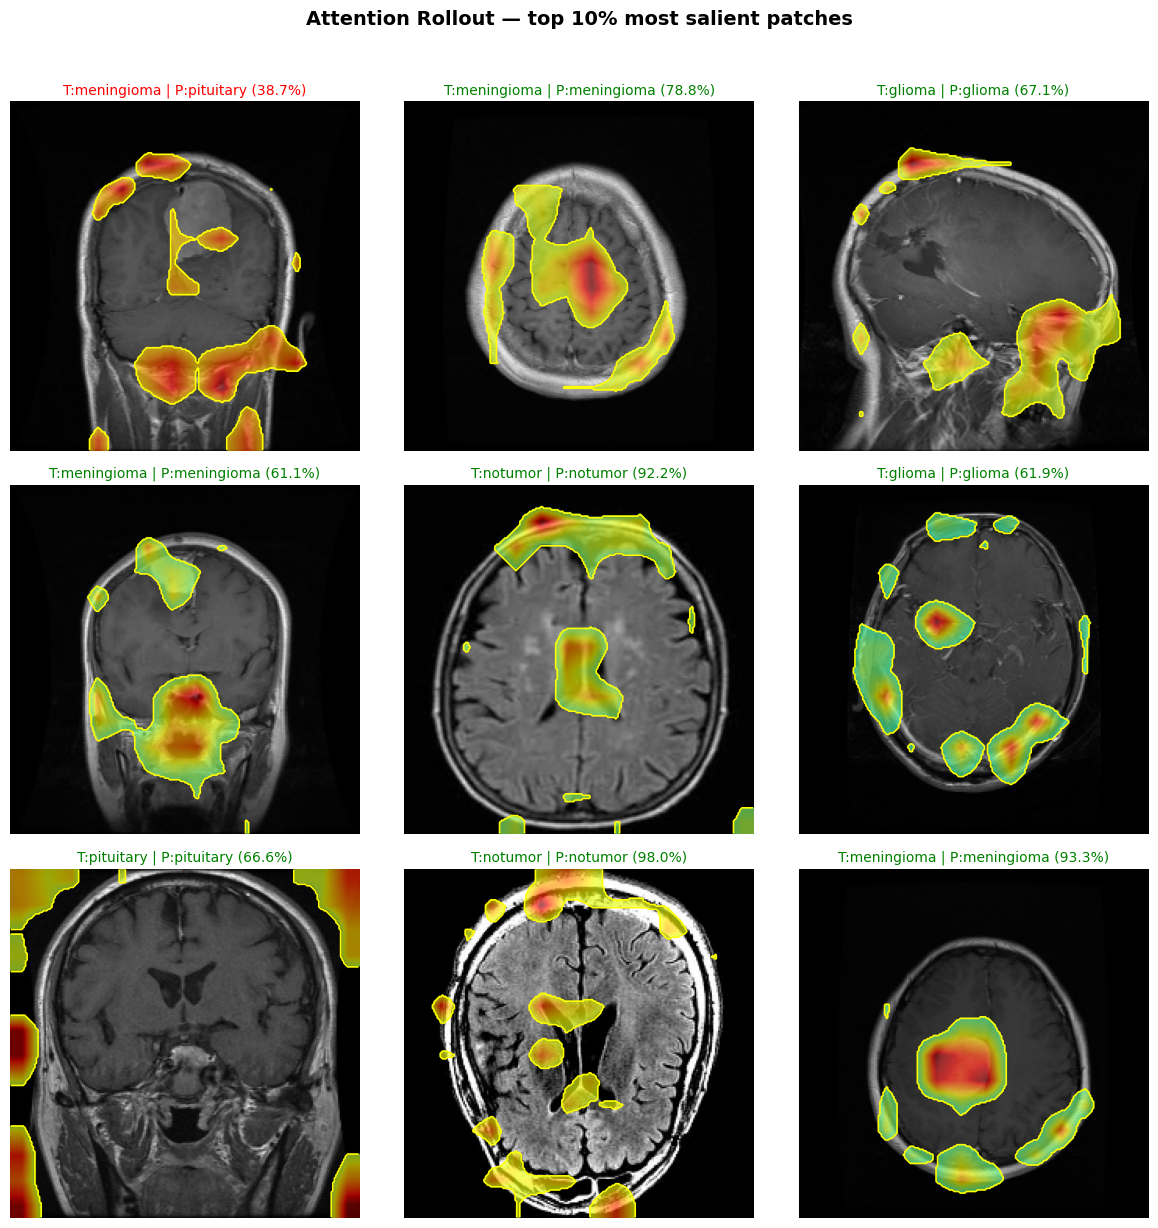

In [30]:
def vit_attention_rollout(backbone, images_nhwc, img_size=(224, 224)):
    """
    Compute Attention Rollout maps for ViT.
    Returns [B, H, W, 1] normalized in [0,1].
    """
    # Preprocess for ViT
    x = (images_nhwc - 0.5) / 0.5
    x = tf.transpose(x, [0, 3, 1, 2])  # NHWC -> NCHW
    outs = backbone(pixel_values=x, output_attentions=True, training=False)
    attns = outs.attentions  # list of L tensors: [B, Heads, T, T]

    joint = None
    for a in attns:
        a = tf.reduce_mean(a, axis=1)   # average over heads -> [B, T, T]
        T = tf.shape(a)[-1]
        eye = tf.eye(T, batch_shape=[tf.shape(a)[0]])
        a = a + eye                      # add skip connection
        a = a / tf.reduce_sum(a, axis=-1, keepdims=True)  # row-normalize
        joint = a if joint is None else tf.matmul(a, joint)

    cls_attn = joint[:, 0, 1:]  # [CLS] -> patches
    grid = int(tf.math.sqrt(tf.cast(tf.shape(cls_attn)[-1], tf.float32)))
    grid = int(grid)            # should be 14 for ViT-B/16 @ 224
    maps = tf.reshape(cls_attn, [-1, grid, grid, 1])
    maps = tf.image.resize(maps, img_size, method="bilinear")

    # Normalize per-sample
    m_min = tf.reduce_min(maps, axis=[1, 2, 3], keepdims=True)
    m_max = tf.reduce_max(maps, axis=[1, 2, 3], keepdims=True)
    maps = (maps - m_min) / (m_max - m_min + 1e-8)
    return maps.numpy()

def show_attention_overlays_topk(model, backbone, dataset, class_names,
                                 n=9, top_pct=0.25, alpha=0.5,
                                 use_contour=True, save_dir=None, fname_prefix="attn_grid",
                                 dpi=180):
    """
    Display n images with Attention Rollout overlays:
    - top_pct: keep only the top percentage of salient patches (e.g., 0.25)
    - alpha: overlay transparency
    - use_contour: draw a contour around salient regions
    - save_dir: optional directory to save the figure
    """
    xb, yb = next(iter(dataset))
    xb = xb[:n]
    y_true = np.argmax(yb.numpy()[:n], axis=1)

    probs = model.predict(xb, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    conf   = probs.max(axis=1) * 100

    attn_maps = vit_attention_rollout(backbone, xb, img_size=(xb.shape[1], xb.shape[2]))

    rows, cols = int(math.ceil(n / 3)), 3
    plt.figure(figsize=(4 * cols, 4 * rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        base = xb[i].numpy()
        attn = attn_maps[i, ..., 0]

        # Quantile threshold to keep top patches
        thr = np.quantile(attn, 1.0 - float(top_pct))
        mask = attn >= thr

        # Base image (gray) + attention overlay
        plt.imshow(base, cmap="gray")
        im = plt.imshow(attn, cmap="jet", interpolation="bilinear")
        im.set_alpha(np.where(mask, alpha, 0.0))

        if use_contour:
            plt.contour(mask.astype(float), levels=[0.5], colors="yellow", linewidths=1.2)

        ok = (y_true[i] == y_pred[i])
        title = f"T:{class_names[y_true[i]]} | P:{class_names[y_pred[i]]} ({conf[i]:.1f}%)"
        ax.set_title(title, color=("green" if ok else "red"), fontsize=10)
        plt.axis("off")

    plt.suptitle(f"Attention Rollout — top {int(top_pct * 100)}% most salient patches",
                 y=1.02, fontsize=14, fontweight="bold")
    plt.tight_layout()

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, f"{fname_prefix}_top{int(top_pct * 100)}.png")
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
        print(f"Saved figure to: {out_path}")

    plt.show()

# Ensure best weights are loaded
if os.path.exists("vit_brain_mri_finetune.weights.h5"):
    model.load_weights("vit_brain_mri_finetune.weights.h5")
elif os.path.exists("vit_brain_mri_head.weights.h5"):
    model.load_weights("vit_brain_mri_head.weights.h5")

# Show overlays with top 10% most salient patches
show_attention_overlays_topk(
    model, vit_backbone, test_ds, CLASSES,
    n=9, top_pct=0.10, alpha=0.65, use_contour=True,
    save_dir="attn_figs", fname_prefix="top10"
)

## Conclusions & Next Steps

**What worked**
- **Two-stage training** (head-only > light fine-tuning) offered stable gains with minimal overfitting.
- **Warmup + cosine** LR scheduling stabilized early training and improved late-epoch convergence.
- **AdamW + label smoothing + gradient clipping** delivered better calibration and robustness.

**Limitations**
- Dataset size (~6k) is modest for deep models; diversity of scanners/patients may be limited.

**Next steps**
1) **Stratified k-fold cross-validation** for robust metrics.  
2) **Gradual unfreezing** (e.g., 4 layers at a time) with smaller LR.  
3) **Hyperparameter tuning**: warmup %, base/min LR, weight decay, batch size.  
